In [ ]:
import numpy as np
import tweepy
import config
import pyspark
import emoji
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_unixtime, date_format, col, avg, sum, to_timestamp
from pyspark.sql.functions import concat, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import StringType
import findspark
findspark.init()
import yfinance as yf
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(stop_words='english')
import csv
import timeit
import random


# Create a SparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

### part 1: get cryptocurrency

In [2]:
# Fetch BTC trade raw data
today = date.today()
ADA_raw = yf.download('ADA-USD', start=today-timedelta(days=7), end=today) # BTC, ETH, XRP, ADA, DOGE
# ADA_raw.columns = ['date', 'open_price', 'high', 'low', 'close_price', 'adj close', 'volume']

# reset index and move Date column to the first column
ADA_raw = ADA_raw.reset_index().rename(columns={'Date': 'date'})
ADA_raw = ADA_raw.loc[:, ['date', 'Close']]
ADA_raw.head()

l = len(ADA_raw["date"])
a = []
for n in range(l):
    data = [str(ADA_raw["date"][n])[0:10], float(ADA_raw["Close"][n])]
    a.append(data)
    
print(a)

[*********************100%***********************]  1 of 1 completed
[['2023-04-24', 0.3839159905910492], ['2023-04-25', 0.3949190080165863], ['2023-04-26', 0.4014979898929596], ['2023-04-27', 0.40984299778938293], ['2023-04-28', 0.4049319922924042], ['2023-04-29', 0.40278398990631104], ['2023-04-30', 0.39735400676727295]]


In [3]:
day_price_data = spark.createDataFrame(a,["date", "close price"])

day_price_data.show()

+----------+-------------------+
|      date|        close price|
+----------+-------------------+
|2023-04-24| 0.3839159905910492|
|2023-04-25| 0.3949190080165863|
|2023-04-26| 0.4014979898929596|
|2023-04-27|0.40984299778938293|
|2023-04-28| 0.4049319922924042|
|2023-04-29|0.40278398990631104|
|2023-04-30|0.39735400676727295|
+----------+-------------------+



### part 2: get twitter

In [9]:
# Set up Twitter API credentials
consumer_key = config.API_KEY
consumer_secret= config.API_SECRET
access_token= config.ACCESS_TOKEN
access_token_secret = config.ACCESS_TOKEN_SECRET

# Authenticate with Twitter API
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)


# Query Twitter API for tweets
data = tweepy.Cursor(api.search_tweets, q="Cardano OR ADA", until="2023-04-30 00:00:00", lang="en", count=100).items(8000)

# Create an empty list to store the processed data
processed_data_list = []

print("fetching twitter data...")

while True:
    try:
        tweet = data.next()
            
        user_date = tweet.created_at
        user_follower = int(tweet.user.followers_count)
        user_id = int(tweet.id)
        user_text = tweet.text
        final_data = [user_date, user_text, user_follower, user_id]   
            
        processed_data_list.append(final_data)
      
    except StopIteration:
        break

print("total twitter data:", len(processed_data_list))

# Create a DataFrame from the processed data list
twitter_data = spark.createDataFrame(processed_data_list, ["date", "text", "follower", "id"])

twitter_data.show()

fetching twitter data...
total twitter data: 7209
+-------------------+--------------------+--------+-------------------+
|               date|                text|follower|                 id|
+-------------------+--------------------+--------+-------------------+
|2023-04-29 19:57:01|RT @TopCoinLinks:...|     338|1652462019734392834|
|2023-04-29 19:55:07|RT @cryptozup: Wh...|    1750|1652461542011535362|
|2023-04-29 19:53:46|RT @daddymonkey_e...|       0|1652461201174011906|
|2023-04-29 19:52:34|RT @SatoshiOwl: ?...|     150|1652460898957643776|
|2023-04-29 19:50:59|RT @daddymonkey_e...|       0|1652460501731876864|
|2023-04-29 19:50:32|RT @daddymonkey_e...|       1|1652460388200460289|
|2023-04-29 19:47:49|RT @daddymonkey_e...|       0|1652459703383867392|
|2023-04-29 19:44:28|1: Bitcoin price ...|      64|1652458860857241600|
|2023-04-29 19:38:39|1: Bitcoin price ...|     964|1652457397716230145|
|2023-04-29 19:27:53|💵 US$ 0.00000000...|    3337|1652454688183164930|
|2023-04-29 19:

In [10]:
# sentiment analysis model 

analyzer=SentimentIntensityAnalyzer()
def get_vader_score(sentence): 
    compound=analyzer.polarity_scores(sentence)['compound']
    if compound > 0.05: 
        return ['positive',compound]
    elif (compound >= -0.05) and (compound <=0.05): 
        return ['neutral',compound]
    else: 
        return ['negative',compound]

def vader_sentiment(X):
  vader_result=get_vader_score(X)[0]#X.apply(lambda x: get_vader_score(x)[0])
  vader_score = get_vader_score(X)[1]#X.apply(lambda x: get_vader_score(x)[1])
  #vader_score_total = np.mean(vader_score)
  return vader_score

#### data cleaning

In [12]:
# start PySpark transform #####################################################################

# load shedding
cleaned_twitter_data = twitter_data.filter(col("follower") >= 10)

# operator reordering, first use filter bc its selectivity is the highest

cleaned_twitter_data = cleaned_twitter_data.filter(col("id") % 10 != random.randint(0, 9))

# remove emoji
def remove_emoji(col):
  result = emoji.replace_emoji(col, replace="")
  return result

clean_udf = F.UserDefinedFunction(remove_emoji, T.StringType())
tweets_df_cleaned = twitter_data.withColumn("text", clean_udf("text"))


# remove mention 
cleaned_twitter_data = twitter_data.withColumn("text", regexp_replace('text', "@\s*[A-Za-z0-9_]+", ''))

cleaned_twitter_data = cleaned_twitter_data.withColumn("text", regexp_replace("text", "#\s*[A-Za-z0-9_]+", ""))

# remove retweet
cleaned_twitter_data = cleaned_twitter_data.withColumn("text", regexp_replace('text', "RT : ", ''))

# remove links
cleaned_twitter_data = cleaned_twitter_data.withColumn('text', regexp_replace('text', r"http\S+", ''))

cleaned_twitter_data = cleaned_twitter_data.withColumn('text', regexp_replace('text', r"www.\S+", ''))

# remove next line
cleaned_twitter_data = cleaned_twitter_data.withColumn("text", regexp_replace("text", r"\n", ""))

cleaned_twitter_data = cleaned_twitter_data.withColumn('text', regexp_replace('text', '\s+', ' '))

cleaned_twitter_data = cleaned_twitter_data.select(col('date'), col('text'))

# put sentiment analysis here

# sentiment model 

vader_sentiment_udf = F.UserDefinedFunction(vader_sentiment, T.FloatType())
vader_sentiment_twitter_data = cleaned_twitter_data.withColumn("text", vader_sentiment_udf("text"))

# calculate average

vader_sentiment_twitter_data = vader_sentiment_twitter_data.groupBy(date_format(col("date"), "yyyy-MM-dd").alias("date"))
vader_sentiment_twitter_data = vader_sentiment_twitter_data.agg(avg("text").alias("avg_value"))

In [13]:
vader_sentiment_twitter_data.show()

+----------+--------------------+
|      date|           avg_value|
+----------+--------------------+
|2023-04-29| 0.15902398995958367|
|2023-04-28| 0.03677221499046253|
|2023-04-27|0.002421561549821...|
|2023-04-26| 0.14959816590738975|
|2023-04-25| 0.25151037540430227|
|2023-04-24| 0.30741864358273785|
|2023-04-23|0.052318421157066065|
|2023-04-22| 0.12403524156917407|
|2023-04-21|  0.4070333242416382|
+----------+--------------------+



In [ ]:
# save csv
final = vader_sentiment_twitter_data.collect()
with open("./Model/ADA/ADA_vader.csv", 'w', newline='') as f:
    # create the csv writer
    writer = csv.writer(f)
    
    for row in final:
        
        # write a row to the csv file
        writer.writerow(row)

### Part 3: integrate two data

In [ ]:
vader_sentiment_twitter_data.show()

In [ ]:
merged_df = vader_sentiment_twitter_data.join(day_price_data,"date","left")

merged_df = merged_df.dropna()

merged_df.show()

### Part 4: Prediction Model

In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime
from tensorflow.keras.models import load_model

In [3]:
def merge_sentimental_data(sentimental_data_file_path, ADA_data):
  # Load sentimental data in csv
  sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
  zeros = pd.DataFrame([0]*21)
  sentiment_data = pd.concat([zeros, sentiment_data], ignore_index=True)
  # Merge with ADA quant
  merged_data = pd.concat([ADA_data, sentiment_data], axis=1)
  num_rows = len(ADA_data)
  new_data_adjusted = pd.DataFrame([0] * num_rows, index=ADA_data.index)
  new_data_adjusted.iloc[-len(sentiment_data):] = sentiment_data.values
  merged_data = pd.concat([ADA_data, new_data_adjusted], axis=1)
  merged_data.columns = list(ADA_data.columns) + ['sentiment']
  return merged_data

In [4]:
### The code below is for dataset that merge sentimental data ONLY
### The code will be commented until the sentimental data is fetched
def predict(num_days_to_predict, sentimental_data_file_path):
    # Load model, prediction csv
    model_path = './Model/ADA/ADA_model.h5'
    model = load_model(model_path)
    prediction_path = './Model/ADA/ADA_prediction.csv'
    prediction = pd.read_csv(prediction_path)
    error = prediction.iloc[-1, 0] - prediction.iloc[-1, 1]
    ### Fetch ADA-USD data BEGIN ###
    ### CHANGE THIS TO THE FUNCTION USING PYSPARK ###
    today = datetime.date.today()
    ADA_quant = yf.download('ADA-USD', start=today-datetime.timedelta(days=365), end=today)
    ### Fetch ADA-USD data END ###
    new_df=ADA_quant.filter(['Adj Close'])
    # Merge sentimental data
    merged_data = merge_sentimental_data(sentimental_data_file_path, new_df)
    # Create 30 window days slot
    last_30_days = merged_data[-30:].values
    last_30_days_price = merged_data['Adj Close'][-30:].values.reshape(-1, 1)
    last_30_days_sentiment = merged_data['sentiment'][-30:].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    last_30_days_scaled_price = scaler.fit_transform(last_30_days_price)
    sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
    sentiment_values = sentiment_data.values.reshape(-1, 1)
    scaler_sentiment = MinMaxScaler()
    scaled_sentiment = scaler_sentiment.fit_transform(sentiment_values)
    last_30_days_scaled_sentiment = scaler_sentiment.transform(last_30_days_sentiment)
    predictions = []
    predicted_dates = []
    # Predict price
    for _ in range(num_days_to_predict):
        offset = error*(0.5-0.03*_)
        if (offset<0):
          offset = 0
        last_date = merged_data.index[-1]
        X_test = []
        X_test.append(np.hstack((last_30_days_scaled_price.flatten(), last_30_days_scaled_sentiment.flatten())))
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        pred_price_unscaled = scaler.inverse_transform(pred_price)
        predictions.append(pred_price_unscaled[0][0]+offset)
        last_30_days_scaled_price = np.concatenate((last_30_days_scaled_price[1:], pred_price), axis=0)
        predicted_date = last_date + datetime.timedelta(days=_+1)
        predicted_dates.append(predicted_date)
    # print(f"Price of ADA-USD for the next {num_days_to_predict} trading days: {predictions}")
    output_text = f"Price of ADA-USD for the next {num_days_to_predict} trading days: {predictions}"
    print(output_text)
    file_name = f"./Frontend/public/results/ADA/Prediction_{num_days_to_predict}days.txt"
    with open(file_name, 'w') as file:
      file.write(output_text)
    fig, ax = plt.subplots()
    ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
    ax.set(xlabel='Date', ylabel='ADA-USD Price', title=f'Predicted ADA-USD Prices for the Next {num_days_to_predict} Trading Days')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_xlim(predicted_dates[0] - datetime.timedelta(days=2), predicted_dates[0] + datetime.timedelta(days=num_days_to_predict+3))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.savefig(f'./Frontend/src/Components/ADA/Prediction_{num_days_to_predict}days', dpi=300, bbox_inches='tight')
    plt.show()


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 1s 1s/step
Price of ADA-USD for the next 1 trading days: [0.4420212507357025]


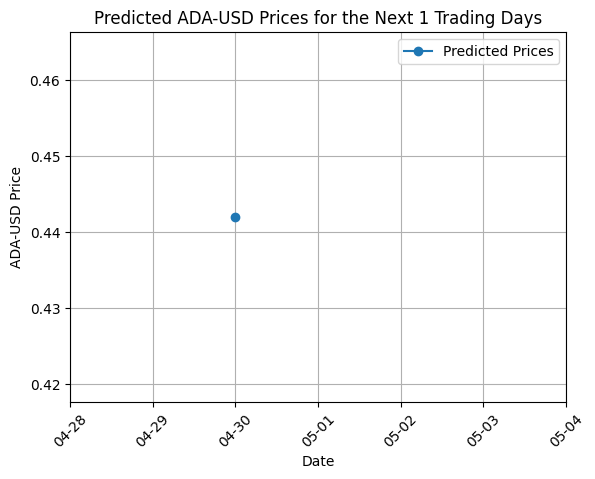

In [6]:
sentimental_data_file_path = './Model/ADA/ADA_vader.csv'
predict(1, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
Price of ADA-USD for the next 3 trading days: [0.4420212507357025, 0.43772264183593135, 0.4343682003117248]


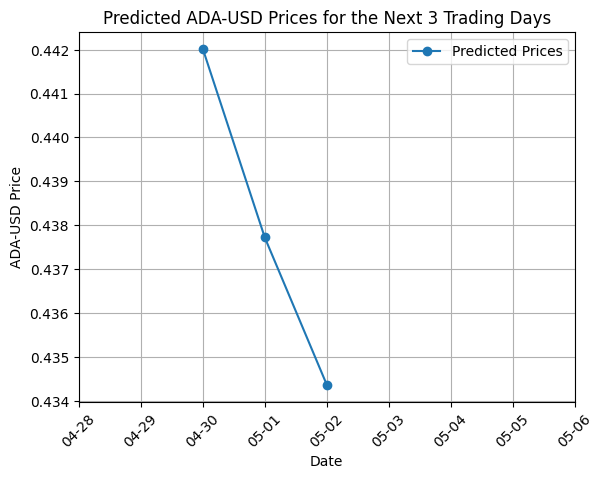

In [7]:
predict(3, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 24ms/step
Price of ADA-USD for the next 5 trading days: [0.4420212507357025, 0.43772264183593135, 0.4343682003117248, 0.4323703605026062, 0.4319371724211639]


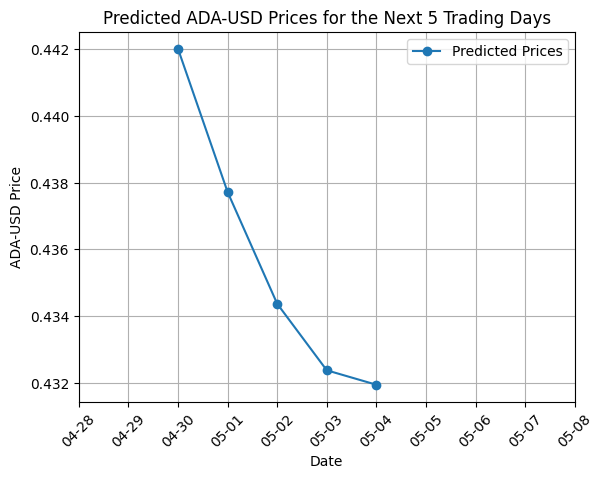

In [8]:
predict(5, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 24ms/step
Price of ADA-USD for the next 30 trading days: [0.4420212507357025, 0.43772264183593135, 0.4343682003117248, 0.4323703605026062, 0.4319371724211639, 0.4328795701341705, 0.43484654188854366, 0.4375431937042572, 0.4406787443217743, 0.4442535513689636, 0.4481222689195404, 0.4515027946270843, 0.4532809388668091, 0.45279702723266296, 0.44876282453711547, 0.44322968423475645, 0.4431373155121399, 0.44628047943115234, 0.44862279295921326, 0.4500088393688202, 0.4504548907279968, 0.4506107568740845, 0.45063650608062744, 0.45060333609580994, 0.4505409002304077, 0.45048418641090393, 0.4504248797893524, 0.4503675699234009, 0.45030438899993896, 0.45028313994407654]


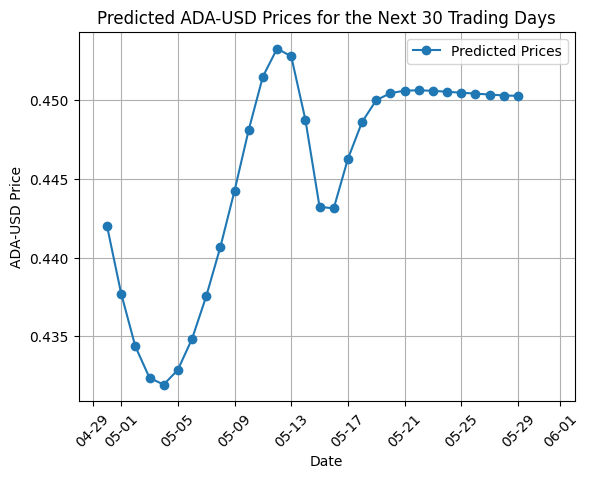

In [9]:
predict(30, sentimental_data_file_path)